In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy import displacy
from spacy import tokenizer
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.models import LsiModel, TfidfModel
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# Set plot option 
plt.rcParams['figure.figsize'] = (10, 6)
default_plot_color = '#00bfbf'

In [3]:
data = pd.read_csv('fake_news_data.csv')
data.head()


,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            198 non-null    object
 1   text             198 non-null    object
 2   date             198 non-null    object
 3   fake_or_factual  198 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


Text(0.5, 1.0, 'Count of article classification')

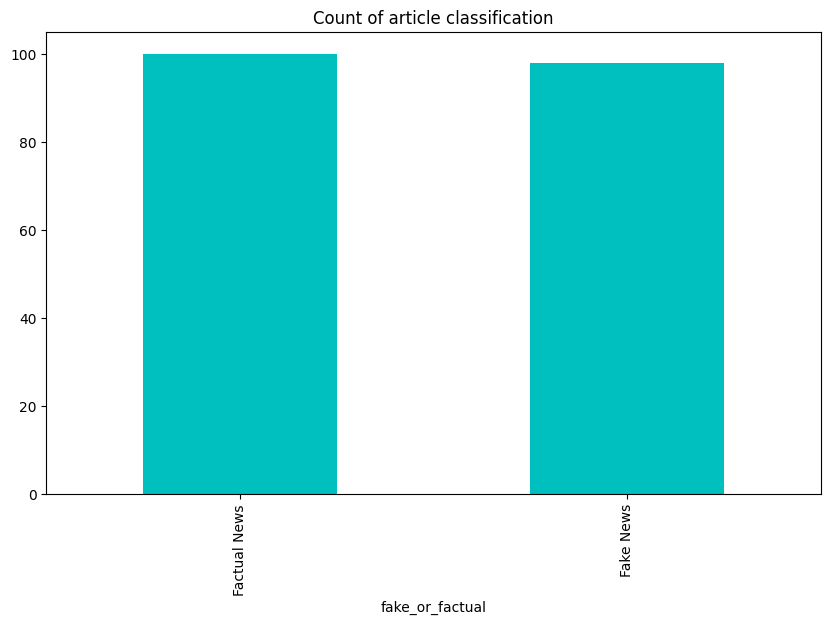

In [5]:
data['fake_or_factual'].value_counts().plot(kind='bar', color=default_plot_color)
plt.title('Count of article classification')



# Parts of Speach (POS)

In [6]:
nlp = spacy.load('en_core_web_sm')

In [7]:
fake_news = data[data['fake_or_factual'] == 'Fake News']
factual_news = data[data['fake_or_factual'] == 'Factual News']

In [8]:
fake_spacy_doc = list(nlp.pipe(fake_news['text']))
factual_spacy_doc = list(nlp.pipe(factual_news['text']))

In [9]:
def extract_token_tags(doc : spacy.tokens.doc.Doc):
    return [(i.text, i.ent_type_, i.pos_) for i in doc]

In [10]:
fake_tagsdf = []
columns = ['token', 'ner_tag', 'pos_tag']

for ix, doc in enumerate(fake_spacy_doc):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags) 
    tags.columns = columns 
    fake_tagsdf.append(tags)


In [11]:
fake_tagsdf = pd.concat(fake_tagsdf)

In [12]:
fact_tagsdf = []

for ix, doc in enumerate(factual_spacy_doc):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags) 
    tags.columns = columns 
    fact_tagsdf.append(tags)

fact_tagsdf = pd.concat(fact_tagsdf)

In [13]:
fake_tagsdf.head()



,token,ner_tag,pos_tag
0,There,,PRON
1,are,,VERB
2,two,CARDINAL,NUM
3,small,,ADJ
4,problems,,NOUN


In [14]:
fact_tagsdf.head()

,token,ner_tag,pos_tag
0,WASHINGTON,GPE,PROPN
1,(,,PUNCT
2,Reuters,ORG,PROPN
3,),,PUNCT
4,-,,PUNCT


In [15]:
pos_counts_fake = fake_tagsdf.groupby(['token', 'pos_tag']).size().reset_index(name='counts').sort_values('counts', ascending=False)
pos_counts_factual = fact_tagsdf.groupby(['token', 'pos_tag']).size().reset_index(name='counts').sort_values('counts', ascending=False)

In [16]:
pos_counts_fake.head()

,token,pos_tag,counts
29,",",PUNCT,1908
7451,the,DET,1834
41,.,PUNCT,1530
5766,of,ADP,922
2665,and,CCONJ,875


In [17]:
pos_counts_factual.head()

,token,pos_tag,counts
6145,the,DET,1903
14,",",PUNCT,1698
21,.,PUNCT,1382
4716,of,ADP,884
1898,a,DET,789


In [18]:
pos_counts_fake.groupby('pos_tag')['token'].count().sort_values(ascending=False)

pos_tag
NOUN     2586
VERB     1817
PROPN    1672
ADJ       882
ADV       413
NUM       221
PRON       96
ADP        89
AUX        62
SCONJ      51
DET        42
INTJ       24
PUNCT      23
CCONJ      19
X          14
PART       10
SYM         5
SPACE       3
Name: token, dtype: int64

In [19]:
pos_counts_factual.groupby('pos_tag')['token'].count().sort_values(ascending=False)

pos_tag
NOUN     2179
VERB     1539
PROPN    1379
ADJ       747
ADV       263
NUM       205
PRON       79
ADP        70
AUX        43
SCONJ      42
DET        36
PUNCT      22
SPACE      11
CCONJ      11
X          10
INTJ        7
PART        7
SYM         4
Name: token, dtype: int64

In [20]:
pos_counts_fake[pos_counts_fake['pos_tag'] == 'NOUN'][:15]

,token,pos_tag,counts
5981,people,NOUN,77
7349,t,NOUN,65
6216,president,NOUN,58
7960,women,NOUN,55
7516,time,NOUN,52
3138,campaign,NOUN,44
8011,year,NOUN,44
4581,government,NOUN,41
5213,law,NOUN,40
8013,years,NOUN,40


In [21]:
pos_counts_factual[pos_counts_factual['pos_tag'] == 'NOUN'][:15]

,token,pos_tag,counts
3738,government,NOUN,71
6618,year,NOUN,64
5901,state,NOUN,57
2360,bill,NOUN,55
1975,administration,NOUN,51
5066,president,NOUN,49
3277,election,NOUN,48
4919,people,NOUN,45
4786,order,NOUN,45
4259,law,NOUN,42


In [22]:
pos_counts_fake[pos_counts_fake['pos_tag'] == 'VERB'][:15]

,token,pos_tag,counts
6763,s,VERB,147
6774,said,VERB,144
4703,have,VERB,76
5171,know,VERB,54
7534,told,VERB,49
5394,made,VERB,45
4645,had,VERB,43
4565,going,VERB,40
4562,go,VERB,40
6797,say,VERB,34


In [23]:
pos_counts_factual[pos_counts_factual['pos_tag'] == 'VERB'][:15]

,token,pos_tag,counts
5567,said,VERB,451
6210,told,VERB,55
3841,have,VERB,43
6649,’s,VERB,35
4021,including,VERB,33
4410,make,VERB,31
4395,made,VERB,29
6072,take,VERB,28
3168,do,VERB,25
5582,saying,VERB,24


# Named Entity Recognition (NER)

In [24]:
top_entities_fake = fake_tagsdf[fake_tagsdf['ner_tag'] != ''].groupby(['ner_tag', 'token']).size().reset_index(name='counts').sort_values('counts', ascending=False)

In [25]:
top_entities_fake.head()

,ner_tag,token,counts
2006,PERSON,Trump,154
1326,ORG,Trump,152
1420,ORG,the,121
1565,PERSON,Clinton,118
1605,PERSON,Donald,75


In [26]:
top_entities_fact = fact_tagsdf[fact_tagsdf['ner_tag'] != ''].groupby(['ner_tag', 'token']).size().reset_index(name='counts').sort_values('counts', ascending=False)

In [27]:
top_entities_fact.head()

,ner_tag,token,counts
1336,ORG,the,159
561,GPE,U.S.,138
1203,ORG,Reuters,131
1860,PERSON,Trump,125
1279,ORG,Trump,124


In [28]:
ner_palette = {
    'ORG' : sns.color_palette('Set2').as_hex()[0],
    'GPE' : sns.color_palette('Set2').as_hex()[1],
    'NORP' : sns.color_palette('Set2').as_hex()[2],
    'PERSON' : sns.color_palette('Set2').as_hex()[3],
    'DATE' : sns.color_palette('Set2').as_hex()[4],
    'CARDINAL' : sns.color_palette('Set2').as_hex()[5],
    'PERCENT' : sns.color_palette('Set2').as_hex()[6]
} 

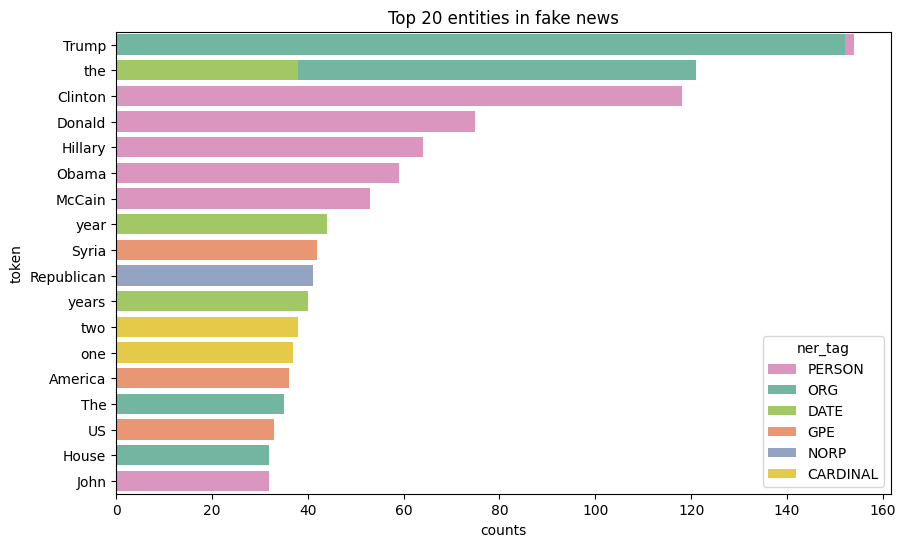

In [29]:
ax = sns.barplot(
    data=top_entities_fake[:20],
    x='counts',
    y='token',
    hue='ner_tag',
    palette=ner_palette,
    orient='h',
    dodge=False
).set_title('Top 20 entities in fake news')

Text(0.5, 1.0, 'Top 20 entities in factual news')

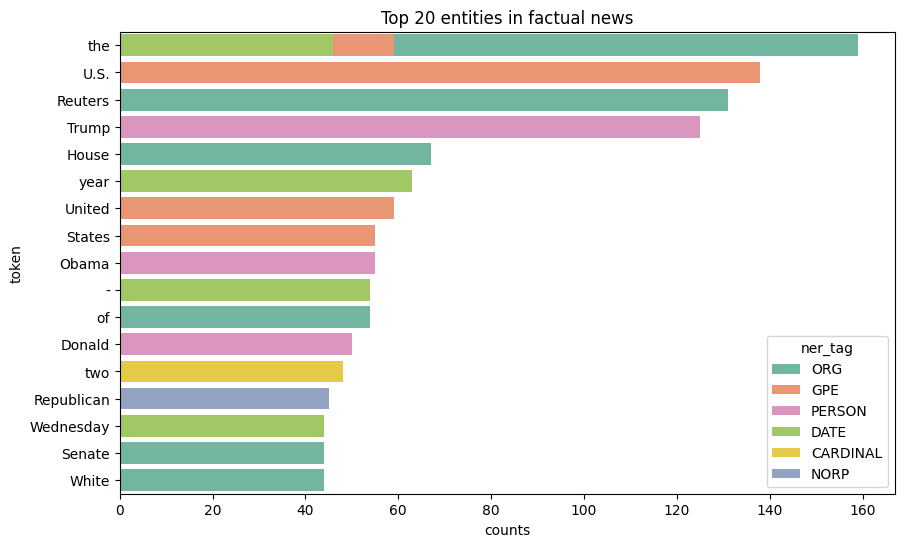

In [30]:
sns.barplot(
    data=top_entities_fact[:20],
    x='counts',
    y='token',
    hue='ner_tag',
    palette=ner_palette,
    orient='h',
    dodge=False
).set_title('Top 20 entities in factual news')

# Text pre-processing

In [31]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [32]:
data['text_clear'] = data.apply(lambda x: re.sub(r"^[^-]*-\s", '', x['text']), axis=1)

In [33]:
data.head()

,title,text,date,fake_or_factual,text_clear
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,There are two small problems with your analogy...
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,Buried in Trump s bonkers interview with New Y...
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"Women make up over 50 percent of this country,..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,U.S. Defense Secretary Jim Mattis said on Mond...
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,Northern Ireland s political parties are rapid...


In [34]:
data['text_clear'] = data['text_clear'].str.lower()

In [35]:
data.head()

,title,text,date,fake_or_factual,text_clear
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,there are two small problems with your analogy...
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,buried in trump s bonkers interview with new y...
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"women make up over 50 percent of this country,..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,u.s. defense secretary jim mattis said on mond...
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,northern ireland s political parties are rapid...


In [36]:
data['text_clear'] = data.apply(lambda x: re.sub(r"([^\w\s])", '', x['text_clear']), axis=1)

In [37]:
data.head()

,title,text,date,fake_or_factual,text_clear
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,there are two small problems with your analogy...
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,buried in trump s bonkers interview with new y...
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,women make up over 50 percent of this country ...
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,us defense secretary jim mattis said on monday...
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,northern ireland s political parties are rapid...


In [38]:
en_stopwords = stopwords.words('english')

In [39]:
data['text_clear'] = data['text_clear'].apply(lambda x: ' '.join([word for word in x.split() if word not in en_stopwords]))

In [40]:
data.head()

,title,text,date,fake_or_factual,text_clear
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,two small problems analogy susan jesus muslim ...
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,buried trump bonkers interview new york times ...
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,women make 50 percent country grossly underrep...
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,us defense secretary jim mattis said monday ru...
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,northern ireland political parties rapidly run...


In [41]:
data['text_clear'] = data.apply(lambda x: word_tokenize(x['text_clear']), axis=1)

In [42]:
lemmatizer = WordNetLemmatizer()
data['text_clear'] = data['text_clear'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

In [43]:
data.head()

,title,text,date,fake_or_factual,text_clear
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m..."
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,..."
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon..."
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,..."


In [44]:
tokens_clean = sum(data['text_clear'], [])

In [45]:
unigrams = (pd.Series(nltk.ngrams(tokens_clean, 1)).value_counts().reset_index())
print(unigrams[:10])



           index  count
0        (said,)    580
1       (trump,)    580
2           (u,)    277
3       (state,)    275
4   (president,)    259
5       (would,)    226
6         (one,)    160
7     (clinton,)    141
8        (year,)    139
9  (republican,)    137


/var/folders/b2/yy5f1_1s1jzgthqcmkwzqxtc0000gn/T/ipykernel_42128/3839647333.py:3: UserWarning: 
The palette list has fewer values (1) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


Text(0.5, 1.0, 'Most common unigrams after pre-processing')

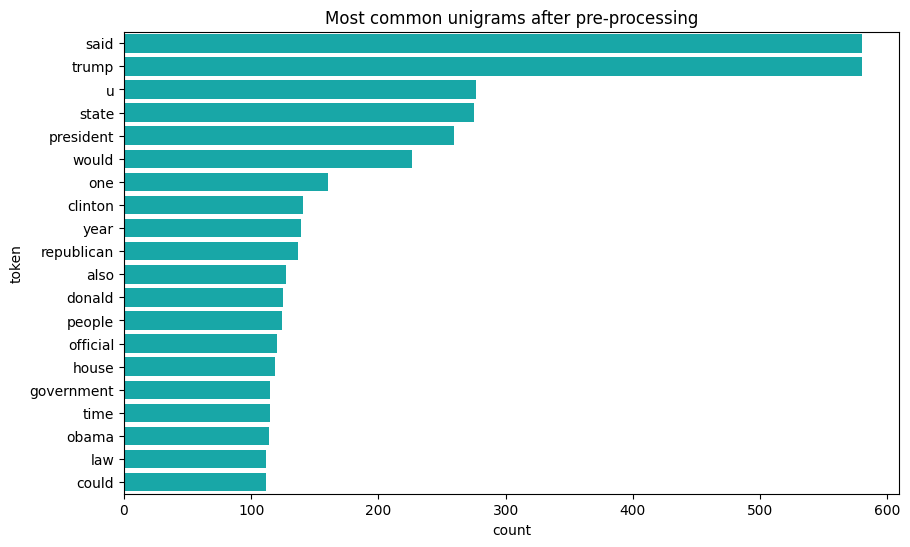

In [46]:
unigrams['token'] = unigrams['index'].apply(lambda x: x[0])

sns.barplot(
    x='count',
    y='token',
    data=unigrams[:20],
    palette=[default_plot_color],
    hue='token',
    orient='h',
    legend=False
).set_title('Most common unigrams after pre-processing')

In [47]:
bigrams = (pd.Series(nltk.ngrams(tokens_clean, 2)).value_counts().reset_index())
print(bigrams[:10])

                     index  count
0          (donald, trump)    113
1          (united, state)     84
2           (white, house)     74
3      (president, donald)     47
4       (hillary, clinton)     39
5              (new, york)     33
6         (supreme, court)     30
7             (image, via)     29
8         (official, said)     26
9  (trump, administration)     26


/var/folders/b2/yy5f1_1s1jzgthqcmkwzqxtc0000gn/T/ipykernel_42128/2696801360.py:3: UserWarning: 
The palette list has fewer values (1) than needed (19) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


Text(0.5, 1.0, 'Most common bigrams after pre-processing')

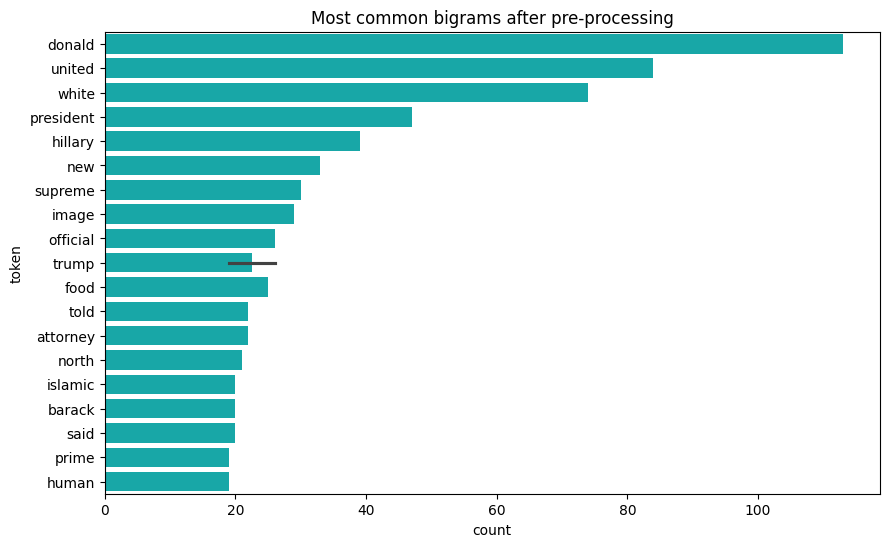

In [48]:
bigrams['token'] = bigrams['index'].apply(lambda x: x[0])

sns.barplot(
    x='count',
    y='token',
    data=bigrams[:20],
    palette=[default_plot_color],
    hue='token',
    orient='h',
    legend=False
).set_title('Most common bigrams after pre-processing')

# Seniment analysis

In [49]:
vader_analyzer = SentimentIntensityAnalyzer()

In [50]:
data['vader_sentiment_score'] = data['text'].apply(lambda x: vader_analyzer.polarity_scores(x)['compound'])

In [51]:
data.head()

,title,text,date,fake_or_factual,text_clear,vader_sentiment_score
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590


In [52]:
bins = [-1, -0.5, 0.5, 1]
labels = ['negative', 'neutral', 'positive']


In [53]:
data['vader_sentiment_label'] = pd.cut(data['vader_sentiment_score'], bins=bins, labels=labels)

In [54]:
data.head()

,title,text,date,fake_or_factual,text_clear,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660,neutral
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,neutral
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


<Axes: xlabel='vader_sentiment_label'>

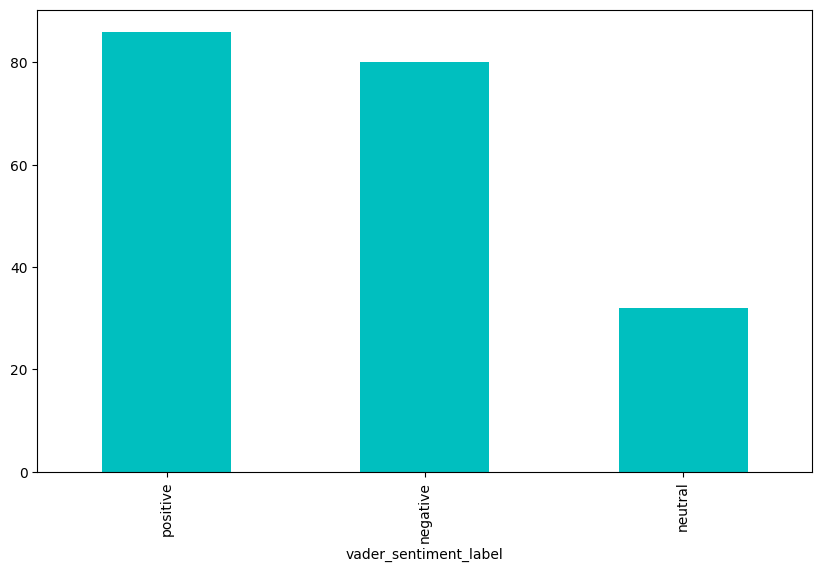

In [55]:
data['vader_sentiment_label'].value_counts().plot.bar(color=default_plot_color)

/var/folders/b2/yy5f1_1s1jzgthqcmkwzqxtc0000gn/T/ipykernel_42128/118997113.py:1: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.countplot(


Text(0.5, 1.0, 'Sentiment analysis of fake and factual news')

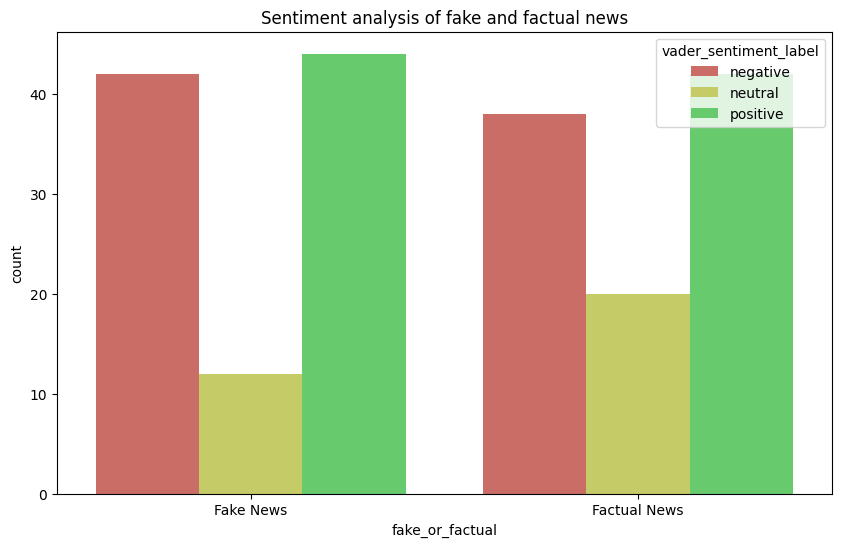

In [56]:
sns.countplot(
    x='fake_or_factual', 
    hue='vader_sentiment_label',
    data=data, 
    palette= sns.color_palette('hls')
).set_title('Sentiment analysis of fake and factual news')

# Topic Modelling

In [57]:
fake_news_text = data[data['fake_or_factual'] == 'Fake News']['text_clear'].reset_index(drop=True)

In [58]:
dictionary_fake = corpora.Dictionary(fake_news_text)

In [59]:
doc_term_fake = [dictionary_fake.doc2bow(text) for text in fake_news_text]

In [60]:
coherence_values = []
model_list = []

min_topics = 2
max_topics = 11

for num_topics_i in range(min_topics, max_topics + 1):
    model = gensim.models.LdaModel(
        corpus=doc_term_fake,
        id2word=dictionary_fake,
        num_topics=num_topics_i    
    )
    model_list.append(model)
    coherencemodel = CoherenceModel(
        model=model,
        texts=fake_news_text,
        dictionary=dictionary_fake,
        coherence='c_v'
    )
    coherence_values.append(coherencemodel.get_coherence())

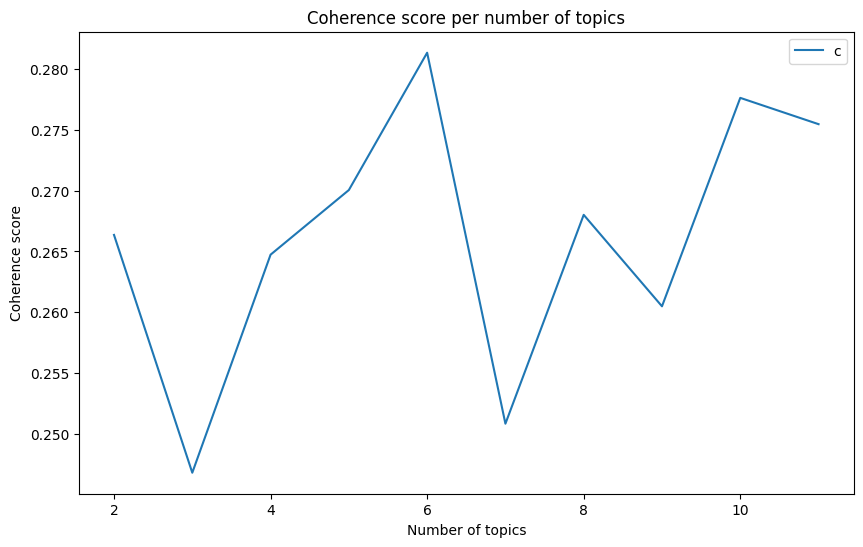

In [61]:
plt.plot(range(min_topics, max_topics + 1), coherence_values)
plt.xlabel('Number of topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.title('Coherence score per number of topics')
plt.show()

In [62]:
num_lda_topics = 6
lda_model = gensim.models.LdaModel(
    corpus=doc_term_fake,
    id2word=dictionary_fake,
    num_topics=num_lda_topics
)



In [63]:
lda_model.print_topics()

[(0,
  '0.010*"trump" + 0.004*"president" + 0.004*"said" + 0.004*"clinton" + 0.004*"would" + 0.004*"time" + 0.004*"u" + 0.003*"state" + 0.003*"know" + 0.003*"people"'),
 (1,
  '0.011*"trump" + 0.005*"said" + 0.005*"state" + 0.005*"clinton" + 0.005*"woman" + 0.004*"one" + 0.004*"president" + 0.003*"would" + 0.003*"two" + 0.003*"donald"'),
 (2,
  '0.013*"trump" + 0.005*"president" + 0.005*"said" + 0.005*"state" + 0.004*"u" + 0.004*"one" + 0.003*"obama" + 0.003*"time" + 0.003*"people" + 0.003*"republican"'),
 (3,
  '0.006*"trump" + 0.005*"mccain" + 0.005*"u" + 0.004*"obama" + 0.004*"would" + 0.004*"year" + 0.004*"syria" + 0.003*"president" + 0.003*"one" + 0.003*"said"'),
 (4,
  '0.008*"trump" + 0.005*"president" + 0.005*"clinton" + 0.004*"said" + 0.004*"state" + 0.004*"republican" + 0.003*"would" + 0.003*"time" + 0.003*"u" + 0.003*"year"'),
 (5,
  '0.017*"trump" + 0.005*"said" + 0.004*"clinton" + 0.004*"would" + 0.003*"donald" + 0.003*"one" + 0.003*"president" + 0.003*"time" + 0.003*"stat

In [64]:
def tfidf_corpus(doc_term_matrix):
    tfidf = TfidfModel(corpus = doc_term_matrix, normalize = True)
    corpus_tfidf = tfidf[doc_term_matrix]
    return corpus_tfidf

In [65]:
def get_coherence_scores(corpus, dictionary, text, min_topics, max_topics):
    coherence_values = []
    model_list = []
    for num_topics_i in range(min_topics, max_topics + 1):
        model = gensim.models.LsiModel(
            corpus=corpus,
            num_topics=num_topics_i,
            id2word=dictionary
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(
            model=model,
            texts=text,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence_values.append(coherencemodel.get_coherence())
    plt.plot(range(min_topics, max_topics + 1), coherence_values)
    plt.xlabel('Number of topics')
    plt.ylabel('Coherence score')
    plt.title('Coherence score per number of topics')
    plt.legend(('coherence_values'), loc='best')
    plt.show()

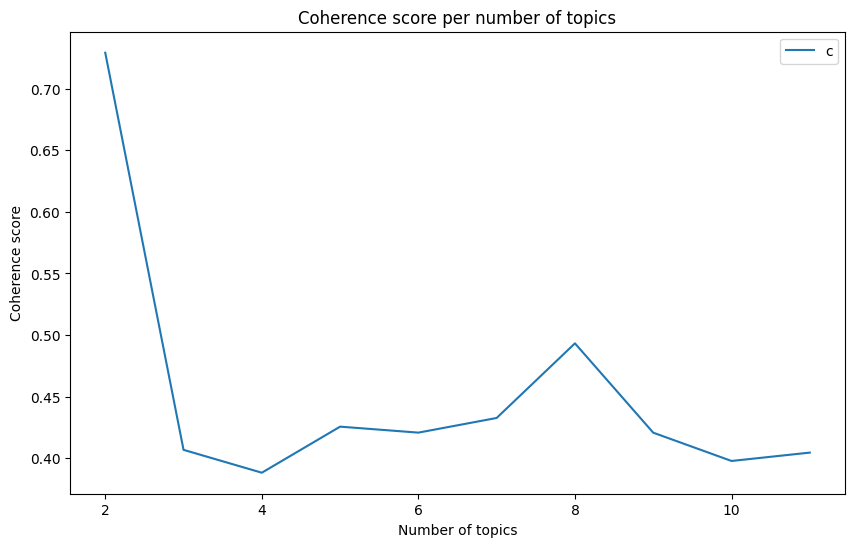

In [66]:
corpus_tfidf = tfidf_corpus(doc_term_fake)
get_coherence_scores(corpus_tfidf, dictionary_fake, fake_news_text, 2, 11)

In [67]:
lsi_model = gensim.models.LsiModel(
    corpus=corpus_tfidf,
    id2word=dictionary_fake,
    num_topics=2
)
lsi_model.print_topics()


[(0,
  '0.190*"trump" + 0.136*"clinton" + 0.095*"hillary" + 0.094*"obama" + 0.089*"president" + 0.087*"woman" + 0.078*"republican" + 0.077*"party" + 0.077*"flynn" + 0.074*"candidate"'),
 (1,
  '0.325*"boiler" + 0.284*"acr" + 0.244*"room" + 0.240*"pm" + 0.186*"broadcast" + 0.180*"radio" + 0.142*"tune" + 0.142*"animal" + 0.134*"jay" + 0.132*"episode"')]

# Creating a classification model 

In [82]:
X = [', '.join(map(str, l)) for l in data['text_clear']]
Y = data['fake_or_factual']

In [83]:
count_vectorizer = CountVectorizer()

In [84]:
count_vect_fit = count_vectorizer.fit_transform(X)

In [85]:
bag_of_words = pd.DataFrame(count_vect_fit.toarray(), columns=count_vectorizer.get_feature_names_out())

In [86]:
X_train, X_test, y_train, y_test = train_test_split(bag_of_words, Y, test_size=0.3)

In [87]:
lr = LogisticRegression(random_state=0).fit(X_train, y_train)

In [95]:
y_pred = lr.predict(X_test)

In [89]:
accuracy_score(y_test, y_pred)

0.9

In [90]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

Factual News       0.94      0.89      0.91        35
   Fake News       0.85      0.92      0.88        25

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60



In [91]:
svm = SGDClassifier().fit(X_train, y_train)

In [92]:
y_pred_svm = svm.predict(X_test)

In [93]:
accuracy_score(y_test, y_pred_svm)

0.9333333333333333

In [94]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

Factual News       0.94      0.94      0.94        35
   Fake News       0.92      0.92      0.92        25

    accuracy                           0.93        60
   macro avg       0.93      0.93      0.93        60
weighted avg       0.93      0.93      0.93        60

